In [1]:
#Run simulation for blog post

In [15]:
#Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [6]:
#Generate dataset of user by day, #signup flag, #conversion flag
NUM_DAYS = 90 # number of days to simulate
BASE_SIGNUP_RATE = 0.02 #Signup rate prior to changing signup flow
BASE_CONVERSION_RATE_FIRST_3_EMAILS = 0.05 #Percent of signups that converted within the first 3 emails
                                           #we assume these users would convert regardless of any change to the content they recieve
BASE_CONVERSION_RATE_4_PLUS_EMAILS = 0.03 #Percent of signups that did not convert within the first 3 emails, that converted
                                          #This is the conversion rate we think we can impact

#Assume the number of users that start sessions on my blog (i.e. land and stay on the page for let's say 10+ seconds)
#Follows some normal distirbution. I get 1,000 sessions per day on average, the with a standard deviation of 50
VISITS_MEAN = 1000
VISITS_SD = 50

#Now let's set some assumptions about how my signup and conversion rate will be affected by the change in signup flow
SIGNUP_RATE_EFFECT_MEAN = 0.001
SIGNUP_RATE_EFFECT_SD = 0.0005
CONVERSION_RATE_EFFECT_MEAN = 0.01
CONVERSION_RATE_EFFECT_SD = 0.005
SEED = 42

#Assume lifetime value of a subscriber of $60. The average subscriber pays the 5 fee for 12 mo
lifetime_value = 5 * 12 

In [7]:
#TODO: Set random seed

def generate_traffic(base_su_rate,base_conv_rate_f3,base_conv_rate_4p,signup_delta,conversion_delta):
    dummy_dict = {}
    for d in range(0,NUM_DAYS):
        num_visits = int(np.random.normal(VISITS_MEAN,VISITS_SD))
        #Generate a unique user for each day
        #Generate random number to determine if a user signed up
        signup_event = [np.random.uniform() for i in range(1,num_visits+1)]
        #Store signup event
        signups = [1 if s <= base_su_rate else 0 for s in signup_event]
        signups_chg = [1 if s <= base_su_rate - signup_delta else 0 for s in signup_event]
        #Determine conversion after 3 emails or fewer (assuming everyone that visited signed-up)
        convert_first_3_emails_u = [1 if np.random.uniform() <= base_conv_rate_f3
                                  else 0 for s in signup_event]
        #Only allow conversions for signups
        convert_first_3_emails = [a*b for a,b in zip(signups,convert_first_3_emails_u)]
        convert_first_3_emails_chg = [a*b for a,b in zip(signups_chg,convert_first_3_emails_u)]

        #List of non-converts for calculating conversion after 3 emails or fewer
        non_convert_first_3_emails = [0 if i == 1 else 1 for i in convert_first_3_emails]
        non_convert_first_3_emails_chg = [0 if i == 1 else 1 for i in convert_first_3_emails]

        #Determine conversion after 3 emails or fewer (assuming everyone that visited signed-up, and didn't convert)
        convert_after_3_emails_u = [1 if np.random.uniform() <= base_conv_rate_4p
                                  else 0 for i in signups]
        convert_after_3_emails_u_chg = [1 if np.random.uniform() <= base_conv_rate_4p + conversion_delta
                                  else 0 for i in signups]
        #Only allow conversions for signups and those that didn't already convert
        convert_after_3_emails = [a*b*c for a,b,c in zip(signups,non_convert_first_3_emails,convert_after_3_emails_u)]
        convert_after_3_emails_chg = [a*b*c for a,b,c in zip(signups_chg,non_convert_first_3_emails_chg,convert_after_3_emails_u_chg)]
        dummy_dict[d] = [signups,convert_first_3_emails,convert_after_3_emails,signups_chg,convert_first_3_emails_chg,convert_after_3_emails_chg]
    return dummy_dict

def calculate_returns(dollar_value,traffic):
    first_3_emails_val = 0
    after_3_emails_val = 0
    first_3_emails_val_chg = 0
    after_3_emails_val_chg = 0
    for d in traffic.keys():
        first_3_emails_val = first_3_emails_val + sum(traffic[d][1])*dollar_value
        after_3_emails_val = after_3_emails_val + sum(traffic[d][2])*dollar_value
        first_3_emails_val_chg = first_3_emails_val_chg + sum(traffic[d][4])*dollar_value
        after_3_emails_val_chg = after_3_emails_val_chg + sum(traffic[d][5])*dollar_value
    return first_3_emails_val, after_3_emails_val, first_3_emails_val + after_3_emails_val, first_3_emails_val_chg, after_3_emails_val_chg, first_3_emails_val_chg + after_3_emails_val_chg
        
    

In [9]:
#Simulate effects of changing the flow
from datetime import datetime
simulation_list = []
n_boot = 100
start = datetime.now()
for i in range(0,n_boot):
    res_dict = {}
    signup_delta = np.random.normal(SIGNUP_RATE_EFFECT_MEAN,SIGNUP_RATE_EFFECT_SD)
    conversion_delta = np.random.normal(CONVERSION_RATE_EFFECT_MEAN,CONVERSION_RATE_EFFECT_SD)
    sim = generate_traffic(BASE_SIGNUP_RATE,
                           BASE_CONVERSION_RATE_FIRST_3_EMAILS,
                           BASE_CONVERSION_RATE_4_PLUS_EMAILS,
                           signup_delta,
                           conversion_delta)
    first_3_emails_base, after_3_emails_base, total_base, first_3_emails_chg, after_3_emails_chg, total_chg = calculate_returns(lifetime_value,sim)
    res_dict['first_3_emails'] = first_3_emails_base
    res_dict['after_3_emails'] = after_3_emails_base
    res_dict['total'] = total_base
    res_dict['first_3_emails_chg'] = first_3_emails_chg
    res_dict['after_3_emails_chg'] = after_3_emails_chg
    res_dict['total_chg'] = total_chg
    simulation_list.append(res_dict)

end = datetime.now()
elapsed = end - start
print(str(elapsed))

0:00:36.707691


In [10]:
df = pd.DataFrame(simulation_list)
df['total_delta'] = df['total_chg'] - df['total']

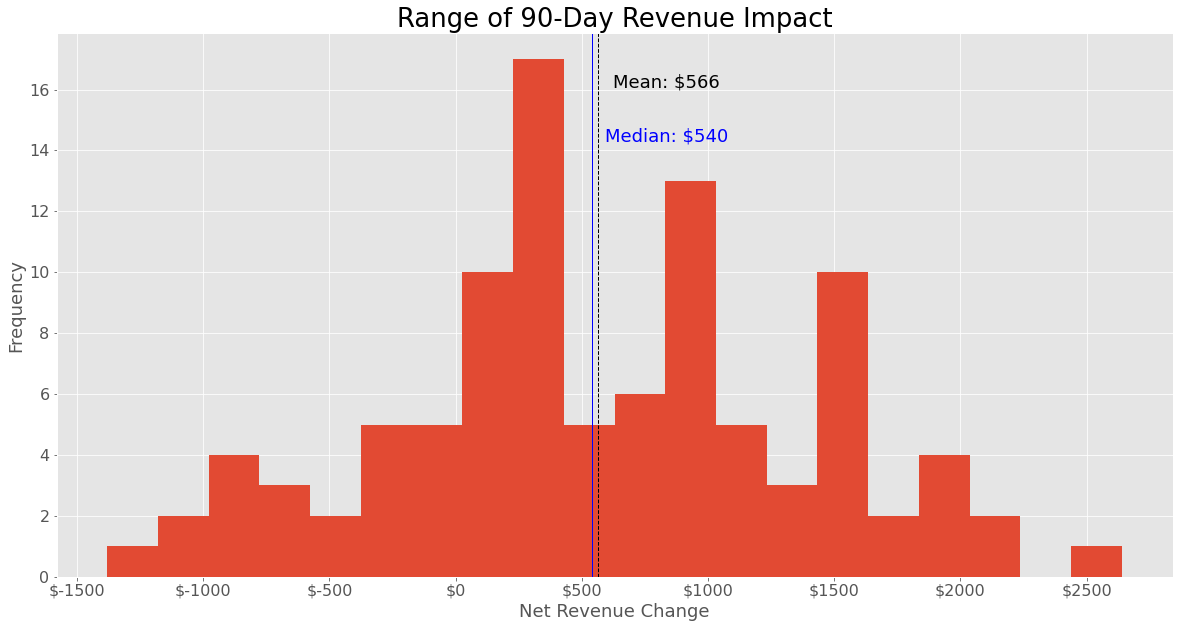

In [57]:
x = df['total_delta']
with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(20,10))
    plt.rcParams['font.size'] = '18'
    ax.set_xlabel('Net Revenue Change', fontsize = 18)
    ax.set_ylabel('Frequency', fontsize = 18) 
    ax.set_title('Range of 90-Day Revenue Impact')
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(16)
    x.plot.hist(bins = 20)
    plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(x.median(), color='b', linewidth=1)
    min_ylim, max_ylim = plt.ylim()
    plt.text(x.mean()*1.1, max_ylim*0.9, 'Mean: ${:.0f}'.format(x.mean()))
    plt.text(x.median()*1.1, max_ylim*0.8, 'Median: ${:.0f}'.format(x.median()), color = 'b')
    formatter = ticker.FormatStrFormatter('$%1.0f')
    ax.xaxis.set_major_formatter(formatter)

In [73]:
print('Probability of Earning More Revenue: {:.0f}%'.format(df['positive_chg'].mean()*100))

Probability of Earning More Revenue: 80%
